In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import copy

In [2]:
root = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/Data/'

data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((64,64)),
                                     transforms.ToTensor()])
dataset = ImageFolder(root, transform=data_transform)

print(dataset.classes)
print(dataset.class_to_idx)

# Split test and train dataset 
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch size of train data loader
batch_size_train = 20

# Set batch size of test data loader
batch_size_test = 22

# load the split train and test data into batches via DataLoader()
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

label_map={
    0:"Chickenpox",
    1:"Measles",
    2:"Monkeypox",
    3:"Normal"
}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders={}
dataloaders["train"]=train_loader
dataloaders["val"]=test_loader

dataset_sizes = {"train":len(train_loader.dataset),"val":len(test_loader.dataset)}

['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


Text(0.5, 1.0, 'Normal')

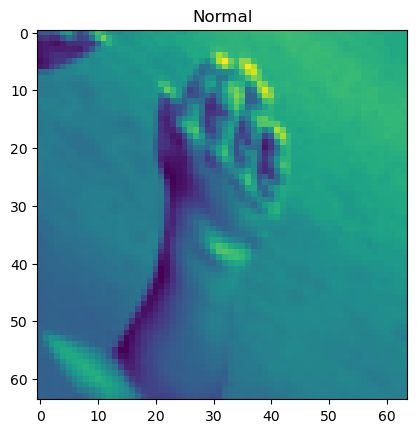

In [3]:
for images, labels in train_loader:
    pass

# Get one batch
images, labels = next(iter(train_loader))

indx=10
plt.imshow(images[indx].reshape(64,64))
plt.title(label_map[int(labels[indx].numpy())])

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs=30

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def accuracy(model, test_loader) :
    model.eval()
    with torch.no_grad():
        running_corrects=0
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        acc = running_corrects.double() / dataset_sizes["val"]
    return acc

In [7]:
from collections import Counter

train_classes = [dataset.targets[i] for i in train_data.indices]
print("train:",Counter(train_classes)) # if doesn' work: Counter(i.item() for i in train_classes)

test_classes = [dataset.targets[i] for i in test_data.indices]
print("Test:",Counter(test_classes)) # if doesn' work: Counter(i.item() for i in train_classes)

print("Total:",dict(Counter(test_data.dataset.targets)))

train: Counter({2: 442, 3: 417, 0: 260, 1: 213})
Test: Counter({2: 188, 3: 168, 0: 116, 1: 100})
Total: {0: 376, 1: 313, 2: 630, 3: 585}


In [8]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/resnet18_net.pth'

#setup model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
torch.save(model_ft.state_dict(), PATH)

# load model
model_ft3 = models.resnet18(pretrained=True)
num_ftrs = model_ft3.fc.in_features
model_ft3.fc = nn.Linear(num_ftrs, len(classes))
model_ft3.to(device)
model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test accuracy
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sajan\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 1.0662 Acc: 0.5488
val Loss: 0.8768 Acc: 0.6521

Epoch 1/29
----------
train Loss: 0.5128 Acc: 0.7913
val Loss: 0.8482 Acc: 0.6469

Epoch 2/29
----------
train Loss: 0.2966 Acc: 0.8799
val Loss: 0.6631 Acc: 0.7360

Epoch 3/29
----------
train Loss: 0.1879 Acc: 0.9317
val Loss: 0.6647 Acc: 0.7255

Epoch 4/29
----------
train Loss: 0.1540 Acc: 0.9392
val Loss: 0.7359 Acc: 0.7483

Epoch 5/29
----------
train Loss: 0.1367 Acc: 0.9542
val Loss: 0.7342 Acc: 0.7255

Epoch 6/29
----------
train Loss: 0.0936 Acc: 0.9722
val Loss: 0.7042 Acc: 0.7692

Epoch 7/29
----------
train Loss: 0.0588 Acc: 0.9835
val Loss: 0.7004 Acc: 0.7640

Epoch 8/29
----------
train Loss: 0.0472 Acc: 0.9880
val Loss: 0.6815 Acc: 0.7762

Epoch 9/29
----------
train Loss: 0.0478 Acc: 0.9895
val Loss: 0.6638 Acc: 0.7815

Epoch 10/29
----------
train Loss: 0.0461 Acc: 0.9887
val Loss: 0.7085 Acc: 0.7745

Epoch 11/29
----------
train Loss: 0.0348 Acc: 0.9962
val Loss: 0.6913 Acc: 0.7762

Ep

In [10]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/alex_net.pth'

# setup
model_ft = models.alexnet(pretrained=True,)
model_ft.classifier[6] = nn.Linear(4096,len(classes))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

# load
model_ft3 = models.alexnet(pretrained=True)
model_ft3.classifier[6] = nn.Linear(4096,len(classes))
model_ft3.to(device)
model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 1.2824 Acc: 0.4332
val Loss: 1.0927 Acc: 0.4808

Epoch 1/29
----------
train Loss: 1.0099 Acc: 0.5526
val Loss: 0.9830 Acc: 0.5647

Epoch 2/29
----------
train Loss: 0.8549 Acc: 0.6291
val Loss: 0.9054 Acc: 0.6224

Epoch 3/29
----------
train Loss: 0.7222 Acc: 0.6892
val Loss: 0.9580 Acc: 0.5769

Epoch 4/29
----------
train Loss: 0.6267 Acc: 0.7432
val Loss: 0.7481 Acc: 0.6696

Epoch 5/29
----------
train Loss: 0.5724 Acc: 0.7470
val Loss: 0.8213 Acc: 0.6311

Epoch 6/29
----------
train Loss: 0.4645 Acc: 0.8063
val Loss: 0.6847 Acc: 0.6958

Epoch 7/29
----------
train Loss: 0.3023 Acc: 0.8739
val Loss: 0.6709 Acc: 0.7168

Epoch 8/29
----------
train Loss: 0.2574 Acc: 0.8934
val Loss: 0.6512 Acc: 0.7220

Epoch 9/29
----------
train Loss: 0.2384 Acc: 0.9024
val Loss: 0.6667 Acc: 0.7185

Epoch 10/29
----------
train Loss: 0.2212 Acc: 0.9099
val Loss: 0.6611 Acc: 0.7098

Epoch 11/29
----------
train Loss: 0.2091 Acc: 0.9249
val Loss: 0.6498 Acc: 0.7255

Ep

In [11]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/densenet201.pth'
model_ft = models.densenet201(pretrained=True,)
# print(model_ft.classifier)
model_ft.classifier=nn.Linear(1920,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)
model_ft3 = models.densenet201(pretrained=True)
model_ft3.classifier=nn.Linear(1920,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 0.9963 Acc: 0.5758
val Loss: 0.8728 Acc: 0.6451

Epoch 1/29
----------
train Loss: 0.4878 Acc: 0.7890
val Loss: 0.5871 Acc: 0.7622

Epoch 2/29
----------
train Loss: 0.2824 Acc: 0.8941
val Loss: 0.6163 Acc: 0.7500

Epoch 3/29
----------
train Loss: 0.2028 Acc: 0.9294
val Loss: 0.5749 Acc: 0.7867

Epoch 4/29
----------
train Loss: 0.1328 Acc: 0.9520
val Loss: 0.5602 Acc: 0.8007

Epoch 5/29
----------
train Loss: 0.0986 Acc: 0.9647
val Loss: 0.5678 Acc: 0.7972

Epoch 6/29
----------
train Loss: 0.0748 Acc: 0.9790
val Loss: 0.6014 Acc: 0.7815

Epoch 7/29
----------
train Loss: 0.0503 Acc: 0.9887
val Loss: 0.5682 Acc: 0.8059

Epoch 8/29
----------
train Loss: 0.0437 Acc: 0.9902
val Loss: 0.5654 Acc: 0.8164

Epoch 9/29
----------
train Loss: 0.0353 Acc: 0.9940
val Loss: 0.5646 Acc: 0.8164

Epoch 10/29
----------
train Loss: 0.0281 Acc: 0.9977
val Loss: 0.5740 Acc: 0.8129

Epoch 11/29
----------
train Loss: 0.0328 Acc: 0.9947
val Loss: 0.5817 Acc: 0.8077

Ep

In [12]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/squeezenet1_1.pth'
model_ft = models.squeezenet1_1(pretrained=True,)
# print(model_ft.classifier)
model_ft.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)
model_ft3 = models.squeezenet1_1(pretrained=True,)
model_ft3.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 1.4030 Acc: 0.3581
val Loss: 1.2296 Acc: 0.4755

Epoch 1/29
----------
train Loss: 1.2049 Acc: 0.4827
val Loss: 1.1060 Acc: 0.5612

Epoch 2/29
----------
train Loss: 1.1538 Acc: 0.5098
val Loss: 1.0824 Acc: 0.5437

Epoch 3/29
----------
train Loss: 1.0582 Acc: 0.5353
val Loss: 1.0178 Acc: 0.5594

Epoch 4/29
----------
train Loss: 0.9627 Acc: 0.5961
val Loss: 0.8460 Acc: 0.6573

Epoch 5/29
----------
train Loss: 0.8596 Acc: 0.6284
val Loss: 0.8022 Acc: 0.6678

Epoch 6/29
----------
train Loss: 0.7705 Acc: 0.6494
val Loss: 0.7540 Acc: 0.6906

Epoch 7/29
----------
train Loss: 0.6367 Acc: 0.7102
val Loss: 0.7057 Acc: 0.6801

Epoch 8/29
----------
train Loss: 0.5838 Acc: 0.7372
val Loss: 0.6867 Acc: 0.6748

Epoch 9/29
----------
train Loss: 0.5530 Acc: 0.7410
val Loss: 0.6750 Acc: 0.6766

Epoch 10/29
----------
train Loss: 0.5509 Acc: 0.7568
val Loss: 0.6780 Acc: 0.6941

Epoch 11/29
----------
train Loss: 0.5355 Acc: 0.7688
val Loss: 0.6457 Acc: 0.6958

Ep

In [13]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/squeezenet1_0.pth'

# setup
model_ft = models.squeezenet1_0(pretrained=True,)
model_ft.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
torch.save(model_ft.state_dict(), PATH)

# load
model_ft3 = models.squeezenet1_0(pretrained=True,)
model_ft3.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 1.3416 Acc: 0.4204
val Loss: 1.2709 Acc: 0.4161

Epoch 1/29
----------
train Loss: 1.1502 Acc: 0.4955
val Loss: 1.0273 Acc: 0.6014

Epoch 2/29
----------
train Loss: 1.0566 Acc: 0.5428
val Loss: 1.0320 Acc: 0.5822

Epoch 3/29
----------
train Loss: 0.9765 Acc: 0.5923
val Loss: 0.8691 Acc: 0.6608

Epoch 4/29
----------
train Loss: 0.8510 Acc: 0.6539
val Loss: 0.8693 Acc: 0.6836

Epoch 5/29
----------
train Loss: 0.7731 Acc: 0.6667
val Loss: 0.6850 Acc: 0.7150

Epoch 6/29
----------
train Loss: 0.6718 Acc: 0.7185
val Loss: 0.7365 Acc: 0.6976

Epoch 7/29
----------
train Loss: 0.5580 Acc: 0.7477
val Loss: 0.6448 Acc: 0.7168

Epoch 8/29
----------
train Loss: 0.4875 Acc: 0.7860
val Loss: 0.6495 Acc: 0.7290

Epoch 9/29
----------
train Loss: 0.4561 Acc: 0.7935
val Loss: 0.6287 Acc: 0.7203

Epoch 10/29
----------
train Loss: 0.4421 Acc: 0.7950
val Loss: 0.6388 Acc: 0.7290

Epoch 11/29
----------
train Loss: 0.4179 Acc: 0.8168
val Loss: 0.6162 Acc: 0.7430

Ep

In [14]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/densenet161.pth'

# setup model
model_ft = models.densenet161(pretrained=True,)
model_ft.classifier=nn.Linear(2208,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train and save
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
torch.save(model_ft.state_dict(), PATH)

# laod model
model_ft3 = models.densenet161(pretrained=True)
model_ft3.classifier=nn.Linear(2208,len(classes))
model_ft3.to(device)
model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test model
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 0.9763 Acc: 0.5743
val Loss: 0.8787 Acc: 0.6259

Epoch 1/29
----------
train Loss: 0.4473 Acc: 0.8138
val Loss: 0.6059 Acc: 0.7133

Epoch 2/29
----------
train Loss: 0.2923 Acc: 0.8889
val Loss: 0.5872 Acc: 0.7535

Epoch 3/29
----------
train Loss: 0.2104 Acc: 0.9174
val Loss: 0.5084 Acc: 0.7902

Epoch 4/29
----------
train Loss: 0.1460 Acc: 0.9467
val Loss: 0.6511 Acc: 0.7815

Epoch 5/29
----------
train Loss: 0.1004 Acc: 0.9655
val Loss: 0.5427 Acc: 0.7972

Epoch 6/29
----------
train Loss: 0.0682 Acc: 0.9827
val Loss: 0.6127 Acc: 0.7955

Epoch 7/29
----------
train Loss: 0.0416 Acc: 0.9880
val Loss: 0.6177 Acc: 0.8112

Epoch 8/29
----------
train Loss: 0.0463 Acc: 0.9880
val Loss: 0.5846 Acc: 0.8059

Epoch 9/29
----------
train Loss: 0.0346 Acc: 0.9940
val Loss: 0.5738 Acc: 0.8077

Epoch 10/29
----------
train Loss: 0.0335 Acc: 0.9925
val Loss: 0.6326 Acc: 0.8129

Epoch 11/29
----------
train Loss: 0.0305 Acc: 0.9947
val Loss: 0.5964 Acc: 0.8164

Ep

In [15]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/densenet169.pth'

# setup
model_ft = models.densenet169(pretrained=True,)
print(model_ft.classifier)
model_ft.classifier=nn.Linear(1664,len(classes))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

#load
model_ft3 = models.densenet169(pretrained=True)
model_ft3.classifier=nn.Linear(1664,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

#test
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=1664, out_features=1000, bias=True)
Epoch 0/29
----------
train Loss: 1.0045 Acc: 0.5608
val Loss: 0.6471 Acc: 0.7098

Epoch 1/29
----------
train Loss: 0.4806 Acc: 0.8026
val Loss: 0.5425 Acc: 0.7570

Epoch 2/29
----------
train Loss: 0.3053 Acc: 0.8806
val Loss: 0.5402 Acc: 0.7657

Epoch 3/29
----------
train Loss: 0.2053 Acc: 0.9257
val Loss: 0.4834 Acc: 0.7780

Epoch 4/29
----------
train Loss: 0.1488 Acc: 0.9467
val Loss: 0.6166 Acc: 0.7483

Epoch 5/29
----------
train Loss: 0.1035 Acc: 0.9632
val Loss: 0.6274 Acc: 0.7797

Epoch 6/29
----------
train Loss: 0.0849 Acc: 0.9737
val Loss: 0.5733 Acc: 0.7955

Epoch 7/29
----------
train Loss: 0.0484 Acc: 0.9910
val Loss: 0.6351 Acc: 0.8059

Epoch 8/29
----------
train Loss: 0.0613 Acc: 0.9835
val Loss: 0.6878 Acc: 0.7832

Epoch 9/29
----------
train Loss: 0.0410 Acc: 0.9887
val Loss: 0.6568 Acc: 0.8077

Epoch 10/29
----------
train Loss: 0.0434 Acc: 0.9932
val Loss: 0.6153 Acc: 0.8059

Epoch 11/29
----------
train Lo

In [16]:
PATH = 'C:/Users/sajan/OneDrive/Desktop/Main Project/Project/densenet121.pth'
model_ft = models.densenet121(pretrained=True,)
model_ft.classifier=nn.Linear(1024,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)
model_ft3 = models.densenet121(pretrained=True)
model_ft3.classifier=nn.Linear(1024,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()
print(accuracy(model_ft3, test_loader))

C:\Users\sajan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 1.0484 Acc: 0.5368
val Loss: 0.7360 Acc: 0.6818

Epoch 1/29
----------
train Loss: 0.5011 Acc: 0.7793
val Loss: 0.6185 Acc: 0.7360

Epoch 2/29
----------
train Loss: 0.2902 Acc: 0.8821
val Loss: 0.6155 Acc: 0.7500

Epoch 3/29
----------
train Loss: 0.1952 Acc: 0.9242
val Loss: 0.5649 Acc: 0.7920

Epoch 4/29
----------
train Loss: 0.1451 Acc: 0.9482
val Loss: 0.5711 Acc: 0.7745

Epoch 5/29
----------
train Loss: 0.1127 Acc: 0.9632
val Loss: 0.5881 Acc: 0.7885

Epoch 6/29
----------
train Loss: 0.0915 Acc: 0.9685
val Loss: 0.6182 Acc: 0.7990

Epoch 7/29
----------
train Loss: 0.0707 Acc: 0.9820
val Loss: 0.6138 Acc: 0.7972

Epoch 8/29
----------
train Loss: 0.0558 Acc: 0.9865
val Loss: 0.6313 Acc: 0.7955

Epoch 9/29
----------
train Loss: 0.0348 Acc: 0.9955
val Loss: 0.6137 Acc: 0.7990

Epoch 10/29
----------
train Loss: 0.0357 Acc: 0.9962
val Loss: 0.6256 Acc: 0.7972

Epoch 11/29
----------
train Loss: 0.0311 Acc: 0.9955
val Loss: 0.6374 Acc: 0.8042

Ep